# PopSpots - Product Recognition PoC 
## Model:  Multiclass Support Vector Machine

In [225]:
import random
import numpy as np
import math
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading and Preprocessing

In [83]:
STANDARD_SIZE = (70, 50)
rootdir = 'C:\Users\Dallas\OneDrive\MSBA Program\Fall 2016 Courses\Adv Predictive Modeling\APM-Project\TrainImages'
labels = []
image_array = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        
        img = cv2.imread(os.path.join(subdir, file))
        img = img[:,:,::-1].astype("float") # Switch from RBG (default for OpenCV) to RGB
        img = cv2.resize(img,STANDARD_SIZE , interpolation = cv2.INTER_AREA)
        
        image_array.append(img)
        
        label = subdir.split(os.path.sep)[-1]
        labels.append(label)

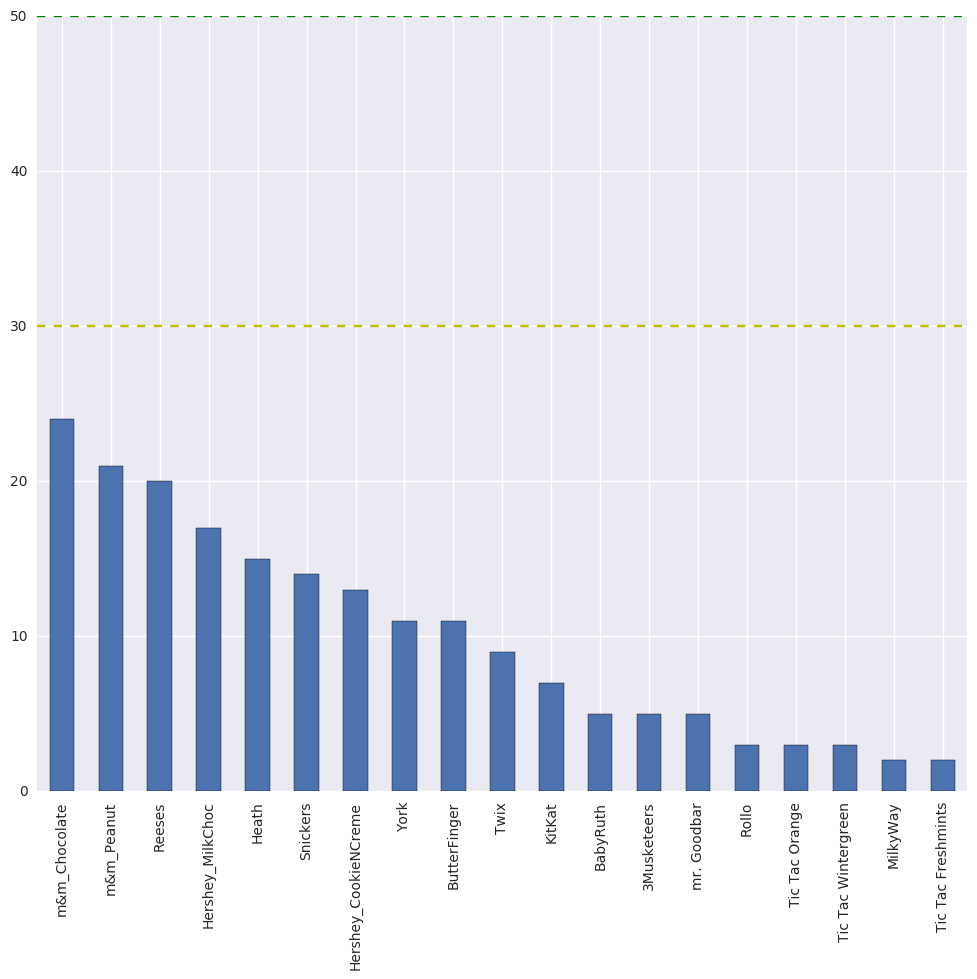

In [109]:
# Load arrays into dataframe for visualization and sub-setting
lab_ser = pd.DataFrame(
    {'product': labels,
     'image_array': image_array,
    })

#Create list of unqiue product names
label_list_all = lab_ser['product'].unique()

lab_ser['product'].value_counts().plot("bar")
plt.axhline(30, color= 'y', linestyle = 'dashed')
plt.axhline(50, color= 'g', linestyle = 'dashed')

In [122]:
# Create a subset for the model containing only classes with image counts above threshold.
img_count_min = 15

# Define training & test split per class
train_samp = 10
test_samp = 5

# Filter for products with minimum number of pictures
lab_ser_top = lab_ser.groupby("product").filter(lambda x: len(x) >= img_count_min)

# Get list of unique labels with image counts above threshold
label_list_top = lab_ser_top['product'].unique()

# Number of products with images above threshold
num_classes = len(label_list)

# Create lists of sub-set
labels_top = lab_ser_top['product'].tolist()
image_array_top = lab_ser_top['image_array'].tolist()

### Visualize Data

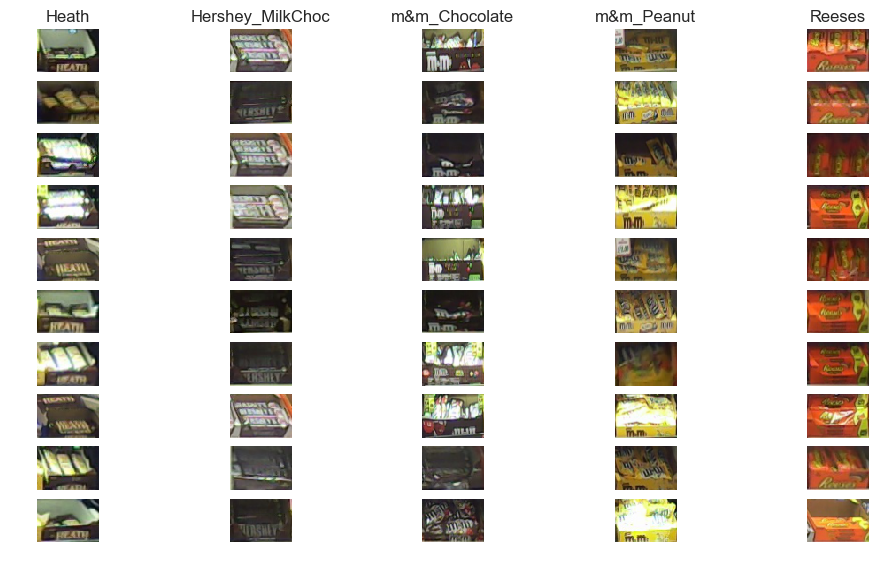

In [121]:
img_per_class = 10

for y, cls in enumerate(label_list):
    
    cls_list = []
    for num, x in enumerate(labels):
        if x == cls:
            cls_list.append(num)
            
    idxs = np.random.choice(cls_list, img_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        img = image_array[idx]
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Split into Training & Test Set

In [123]:
idxs_train = []
idxs_test = []

#Randomly sample training images from each class
for y, cls in enumerate(label_list_top):
    
    cls_list = []
    for num, x in enumerate(labels_top):
        if x == cls:
            cls_list.append(num)
            
    idxs = np.random.choice(cls_list, samples_per_class, replace=False)
    train_idx = idxs[:train_samp]
    test_idx = idxs[train_samp:]
    
    idxs_train.extend(train_idx)
    idxs_test.extend(test_idx)

# Convert list of image arrays into global image array
img_array_concat = np.concatenate([aux[np.newaxis, ...] for aux in image_array_top], axis=0)

# Create training & test sets using sample index
X_train = img_array_concat[idxs_train]
X_test = img_array_concat[idxs_test]

# Create dictionary from label_list so that labels may be converted to a labelID
label_dict = {}
for x,label in enumerate(label_list_top):
    label_dict[label] = x

# Convert labels to integers using label_dict
labels_int = [label_dict[i] for i in labels_top]

y_train = np.asarray(labels_int)[idxs_train]
y_test = np.asarray(labels_int)[idxs_test]

print 'Train images: {}'.format(len(idxs_train))
print 'Test images: {}'.format(len(idxs_test))
print
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train images: 50
Test images: 25

Training data shape:  (50L, 50L, 70L, 3L)
Training labels shape:  (50L,)
Test data shape:  (25L, 50L, 70L, 3L)
Test labels shape:  (25L,)


In [124]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Test data shape: ', X_test.shape

Training data shape:  (50L, 10500L)
Test data shape:  (25L, 10500L)


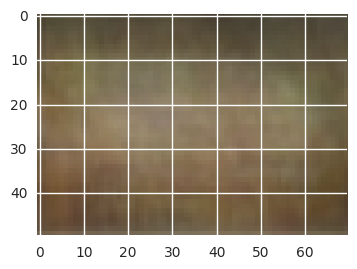

In [125]:
# Preprocessing: subtract the mean image
# Compute the image mean based on training data
mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((50,70,3)).astype('uint8')) # visualize the mean image

In [126]:
# second: subtract mean image from train and test data
X_train -= mean_image
X_test -= mean_image

In [127]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM only has to worry about optimizing single weight matrix W.
# Also, transform both data matrices so that each image is a column.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

print X_train.shape, X_test.shape

(10501L, 50L) (10501L, 25L)


## SVM Classifier

### Stochastic Gradient Descent

In [160]:
# Now implement SGD
from cs231n.classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=8e4,
                      num_iters=600, verbose=True)
toc = time.time()
print
print 'That took %fs' % (toc - tic)

iteration 0 / 600: loss 2120.254656
iteration 100 / 600: loss 420.963815
iteration 200 / 600: loss 84.512884
iteration 300 / 600: loss 17.058639
iteration 400 / 600: loss 3.519506
iteration 500 / 600: loss 0.789975
That took 6.509000s


### Visualize SGD Loss to Find Optimal Iterations

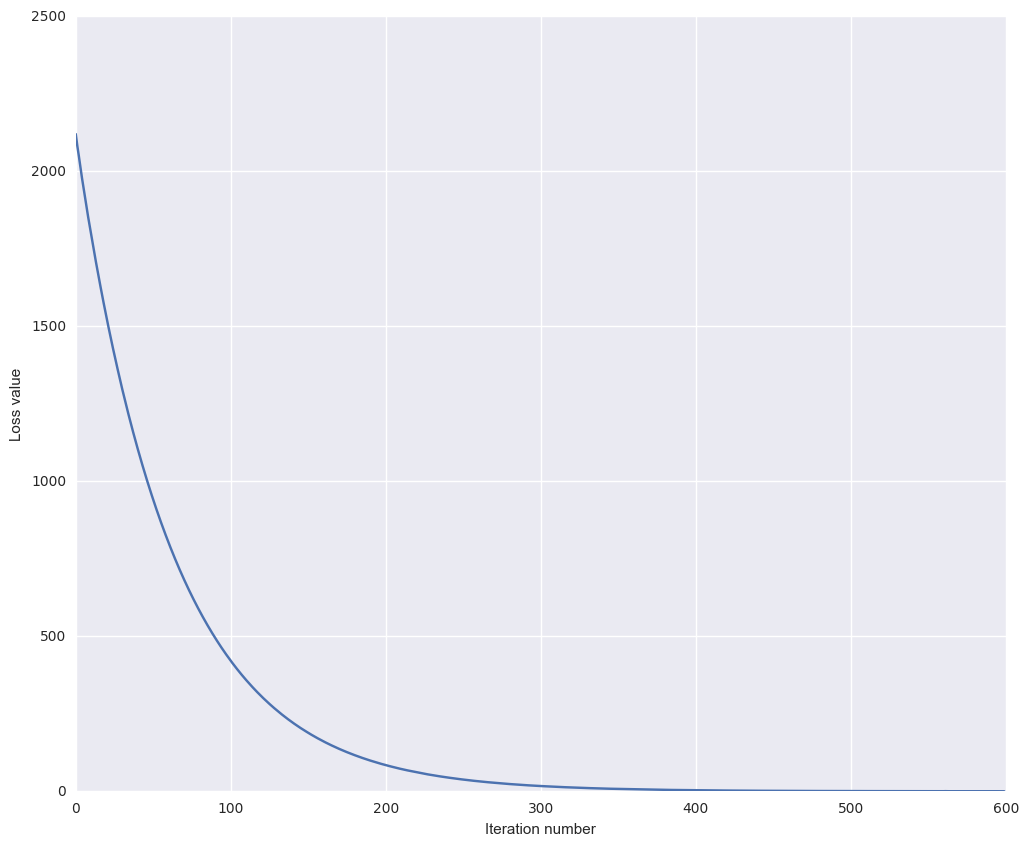

In [161]:
plt.plot(loss_hist)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')

In [162]:
# Write the LinearSVM.predict function and evaluate the performance on both training and test set

y_train_pred = svm.predict(X_train)
print 'Training Accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_test_pred = svm.predict(X_test)
print 'Testing Accuracy: %f' % (np.mean(y_test == y_test_pred), )

training accuracy: 1.000000
testing accuracy: 0.920000


## Cross-Validate to Optimize Hyper-parameters

In [143]:
learning_rates = [1e-7, 2e-7, 3e-7, 5e-5, 8e-7]
regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]

results = {}
best_test = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest test rate.

iters = 600
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iters)
        
        y_train_pred = svm.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_test_pred = svm.predict(X_test)
        acc_test = np.mean(y_test == y_test_pred)
        
        results[(lr, rs)] = (acc_train, acc_test)
        
        if best_test < acc_test:
            best_test = acc_test
            best_svm = svm
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, test_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f test accuracy: %f' % (
                lr, reg, train_accuracy, test_accuracy)
print
print 'best testing accuracy achieved during cross-validation: %f' % best_test

lr 1.000000e-07 reg 1.000000e+04 train accuracy: 1.000000 test accuracy: 0.440000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 1.000000 test accuracy: 0.640000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 1.000000 test accuracy: 0.720000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 1.000000 test accuracy: 0.840000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 1.000000 test accuracy: 0.840000
lr 1.000000e-07 reg 6.000000e+04 train accuracy: 1.000000 test accuracy: 0.920000
lr 1.000000e-07 reg 7.000000e+04 train accuracy: 1.000000 test accuracy: 0.920000
lr 1.000000e-07 reg 8.000000e+04 train accuracy: 1.000000 test accuracy: 0.920000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 1.000000 test accuracy: 0.880000
lr 2.000000e-07 reg 1.000000e+04 train accuracy: 1.000000 test accuracy: 0.680000
lr 2.000000e-07 reg 2.000000e+04 train accuracy: 1.000000 test accuracy: 0.840000
lr 2.000000e-07 reg 3.000000e+04 train accuracy: 1.000000 test accuracy: 0.880000
lr 2.000000e-07 

### Explore Classification Results

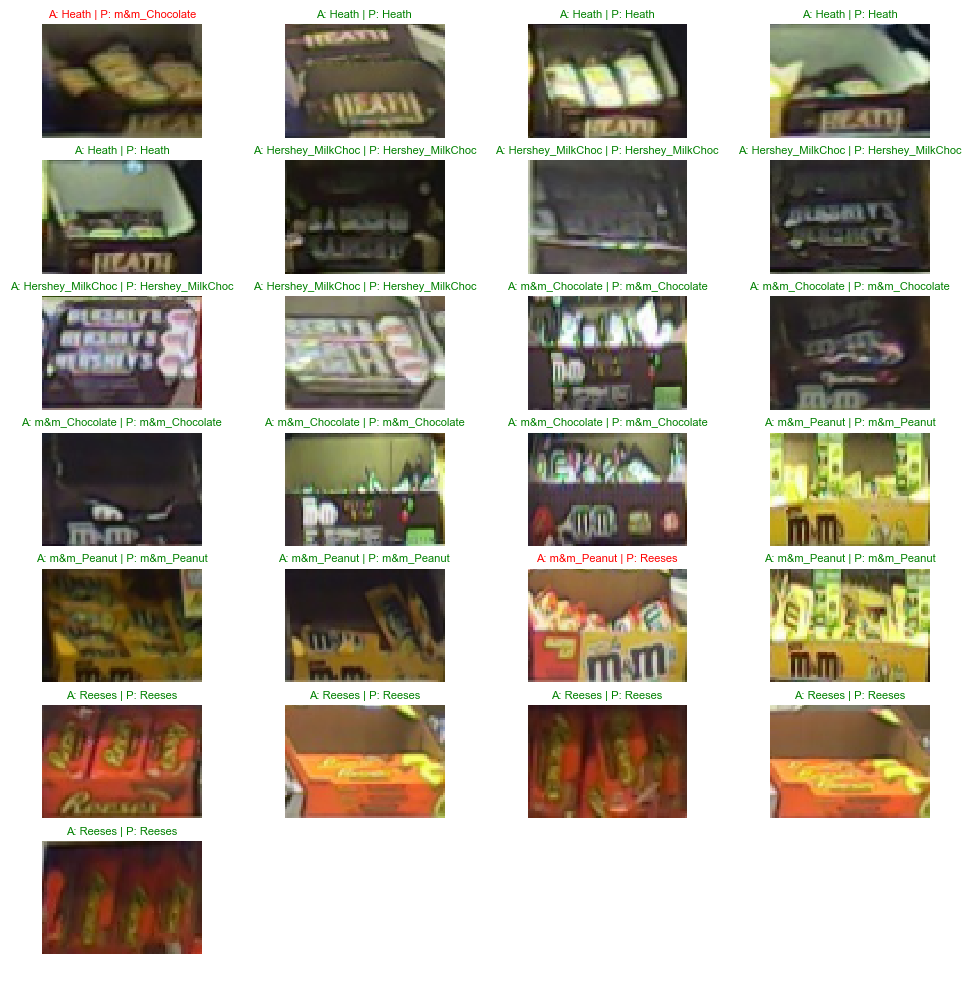

In [256]:
pred_num = len(y_test)

img_w = 4
img_l = int(math.ceil(pred_num*1.0 / img_w))

for x, pred in enumerate(idxs_test):
    
    plt.subplot(img_l, img_w, x+1)
    img = image_array_top[pred]
    
    test_label = y_test_pred[x]
    test_label = (key for key,value in label_dict.items() if value == test_label).next()
    
    # Set color to green if correct, red if wrong
    if labels_top[pred] == test_label:
        c = 'green'
    else:
        c = 'red'
    
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    plt.title('A: {} | P: {}'.format(labels_top[pred],test_label), fontsize=8, color = c)
    
    
plt.show()

### Visualize Learned Weights

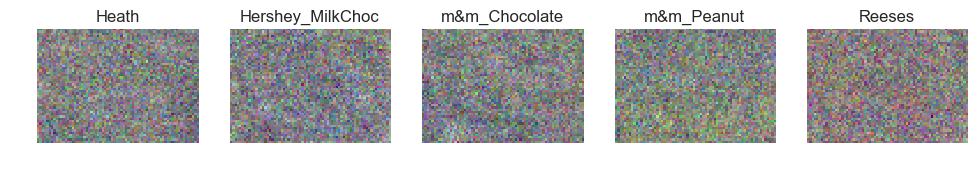

In [190]:
# Visualize the learned weights for each class. 
# Depending on learning rate and regularization strength, these may or may not be nice to look at.
w = best_svm.W[:,:-1] # strip out the bias
w = w.reshape(5, 50, 70, 3)
w_min, w_max = np.min(w), np.max(w)

for i in xrange(5):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(label_list_top[i])